# Time Series Analysis

ARIMA 기법을 실습하기에 앞서, 다루고자 하는 Time Series의 데이터셋의 특성을 분석하는 다양한 방법에 대해 알아보겠습니다.

(참고)
https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
# csv 포맷의 데이터 경로를 지정합니다.
dataset_filepath = 'datasets/airline-passengers.csv'

In [53]:
ts = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True)

In [54]:
ts.columns

Index(['Passengers'], dtype='object')

In [55]:
ts.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [56]:
ts.head(10)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [57]:
ts.tail(10)

,Passengers
Month,
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


ARIMA를 적용하기 위해 가장 먼저 확인해야 할 것은 이 Time series가 ARIMA 모델의 기본 가정인 stationary한지 여부입니다.  
Stationary하다는 것은 variable의 평균(mean), 분산(variance), 자기공분산(autocovariance)이 시간의 흐름에 따라 일정하게 유지되고 있다는 뜻입니다. 지금 우리가 다루려는 데이터가 stationary한지 일단 눈으로 확인해 봅시다.

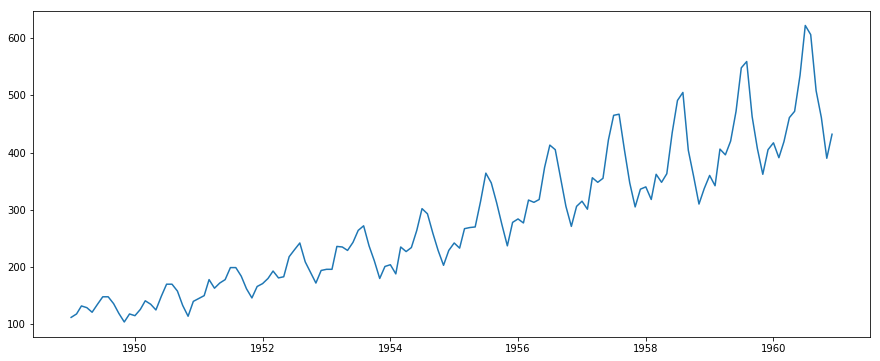

In [58]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

# time series 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)  

이번 데이터셋은 기본 플롯만 살펴봐도 시간에 따른 평균값이나 분산의 증가가 얼른 눈에 띕니다.   
그러나 이렇게 명확하게 Non-stationary함이 드러나지 않는 데이터셋인 경우가 대부분이므로, 좀더 formal하게 stationary 여부를 체크하는 방법들을 적용해 봅시다.다음 두 가지 방법이 주로 사용됩니다.    

#### 1. Plotting Rolling Statistics 
시간 t에서의 moving average, moving variance는 그 시간 t의 직전 window 사이즈 동안의 평균/분산 값을 의미합니다. 여기서는 window=12 로 해서 직전 12개월간의 moving average, moving variance을 시각화해 보겠습니다. 이 방법은 stationary를 정의하는 기준에 더 충실한 접근이긴 하지만 여전히 시각화에 의존하는 정성적 방법입니다.

#### 2. Dickey-Fuller Test
이 방법은 "이 데이터셋이 stationary하지 않다"라는 귀무가설(Null Hypothesis)을 세우고, 이 가설을 입증하는 p-value가 일정 기준(5% 정도)보다 작다는 것을 보여 이 귀무가설을 기각하는 방식으로 이 데이터셋이 stationary함을 확인하는 통계적 가설검정 방법입니다.


(참고) critical value와 p-value의 의미  
https://www.geogebra.org/m/YRh9H3t5

In [82]:
# 1. Plotting Rolling Statistics

def plot_rolling_statistics(timeseries, window=12):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [86]:
# 2. Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


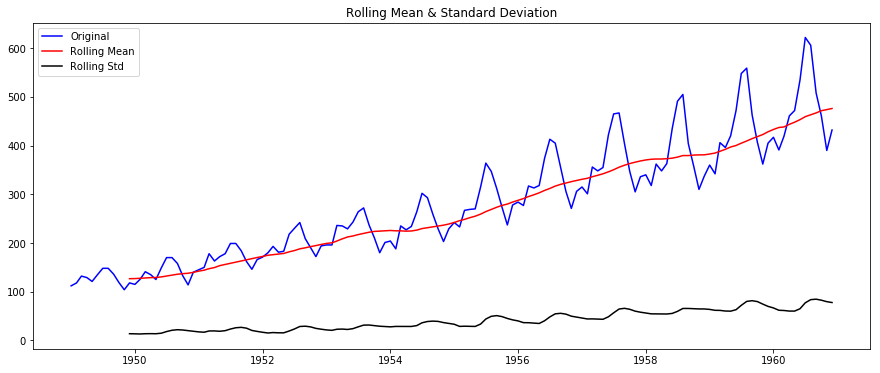

In [87]:
plot_rolling_statistics(ts, 12)

In [88]:
dickey_fuller_test(ts['Passengers'])
# (주의) dickey_fuller_test(ts)는 에러가 발생합니다.

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Dickey-Fuller Test 수행결과 p-value가 무려 0.99가 나옵니다. Non-stationary하다는 가설이 매우 타당하다는 의미입니다.  
그렇다면 이 데이터셋에는 Time Series Analysis를 적용해 볼 수 없는걸까요?  

이 데이터셋에는 Trend(평균과 분산의 분포가 시간에 따라 우상향), Seasonality(매년 계절별로 일정한 증감 패턴)이 뚜렷이 나타납니다.  
혹시 이런 일정한 규칙의 패턴을 제거해 준다면 현재의 데이터셋에서 Stationary한 Time Series를 뽑아낼 수 있지 않을까요?

#### log transformation  
데이터셋이 우상향 Trend를 가진다면 log transform을 고려해 볼 만 합니다.

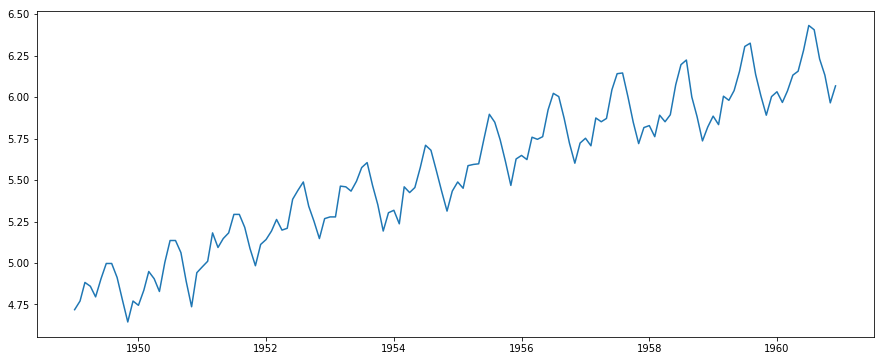

In [107]:
ts_log = np.log(ts)
plt.plot(ts_log)

Variance의 시간별 우상향 trend가 많이 사라진 것을 확인할 수 있습니다.

#### Moving average 제거  

ts_log 에서 average의 시간별 우상향 trend를 제거해 봅시다.

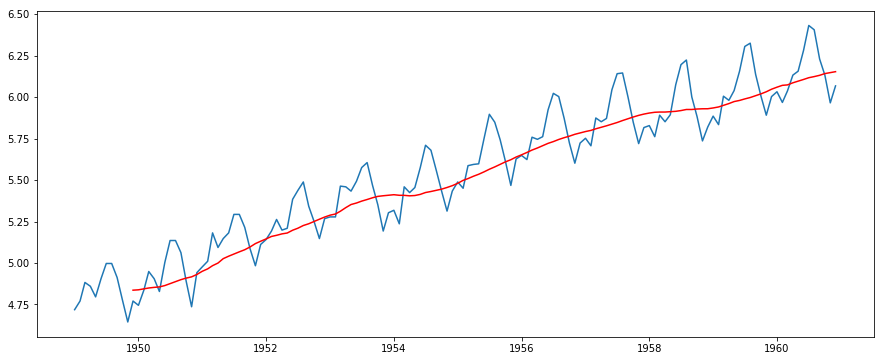

In [108]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [109]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(15)

,Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


Moving Average 계산시 (windows size=12인 경우) 앞의 11개의 데이터는 Moving Average가 계산되지 않으므로 NaN이 발생합니다.  
이 값들은 향후 Dicky-Fuller Test 시에 에러를 발생시킬 것이므로 이를 데이터셋에서 제거해 줍니다.

In [110]:
ts_log_moving_avg_diff.dropna(inplace=True)

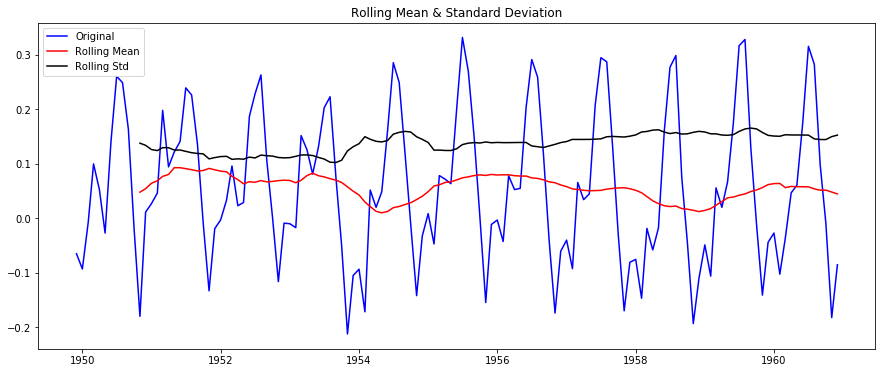

In [111]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [112]:
dickey_fuller_test(ts_log_moving_avg_diff['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


p-value가 0.02 수준이므로 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있겠습니다.  

그러나 지금까지의 접근에서 한가지 숨겨진 문제점이 있습니다.  
바로 Moving Average를 계산하는 window=12으로 정확하게 지정해 주어야 한다는 점입니다.  
위 코드에서 window=6으로 입력해서 test를 수행하면 p-value=0.18이 나옵니다. 여전히 Non-stationary한 데이터셋이 되는 것이지요.

#### Exponential weighted moving average 제거  

Exponential weighted moving average를 통해서 좀더 정밀하게 Trend를 제거해 보겠습니다.

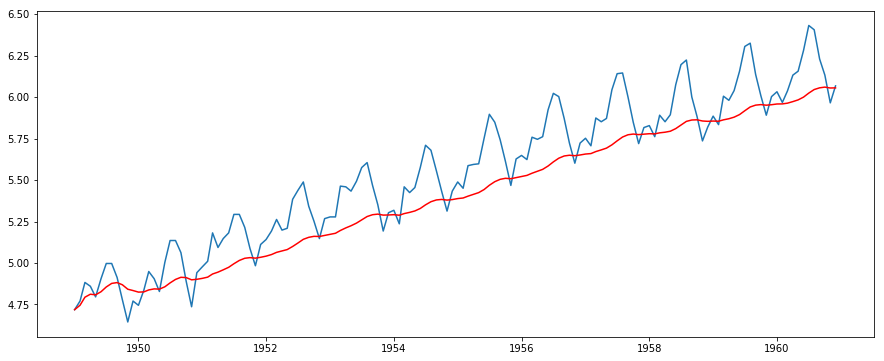

In [113]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

In [114]:
ts_log_ewma_diff = ts_log - expwighted_avg

plot_rolling_statistics(ts_log_ewma_diff)

In [116]:
dickey_fuller_test(ts_log_ewma_diff['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


p-value가 훨씬 더 낮아졌습니다. EWMA를 통해 더욱 stationary한 time series를 얻을 수 있게 되었습니다.  

그러나 우리는 아직 seasonality를 고려하지 않았습니다.   
이번에는 trend와 seasonality를 제거하기 위해 이전처럼 rolling에만 의존하지 않고 데이터의 변화 관점에서 다른 접근법을 검토해 보겠습니다.

#### Differencing

Differencing은 time series의 매 타임스텝별 변화량을 관측하는 것입니다.

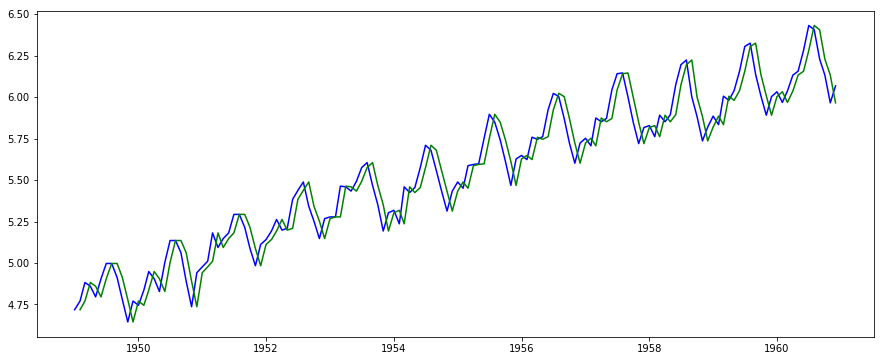

In [119]:
ts_log_shift = ts_log.shift()   

plt.plot(ts_log, color='blue')
plt.plot(ts_log_shift, color='green')

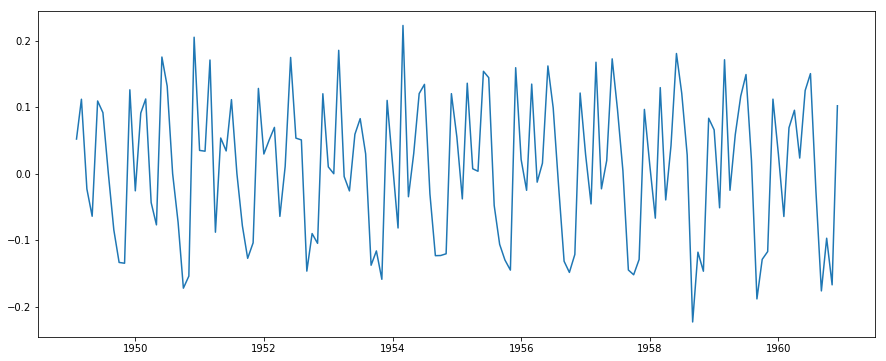

In [120]:
ts_log_diff = ts_log - ts_log_shift
plt.plot(ts_log_diff)

differencing만으로도 stationality가 높아지는 것을 확인할 수 있습니다. 실제로 그러한지 확인해 보겠습니다.

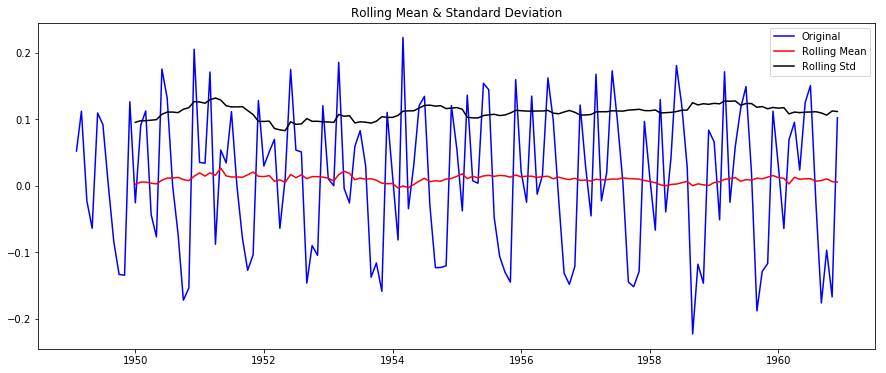

In [121]:
plot_rolling_statistics(ts_log_diff)

In [123]:
ts_log_diff.dropna(inplace=True)
dickey_fuller_test(ts_log_diff['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


1st order differencing 결과 p-value=0.07 수준의 stationality를 확인했습니다. confidence 90% 수준에서 stationary하다고 볼 수 있습니다.  

2nd 또는 3rd order differencing을 통해 좀더 stationality가 높은 time series 도출이 가능해집니다.

#### Decomposing  

statsmodels 라이브러리 안에 seasonal_decompose 메소드를 통해 time series 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있습니다.

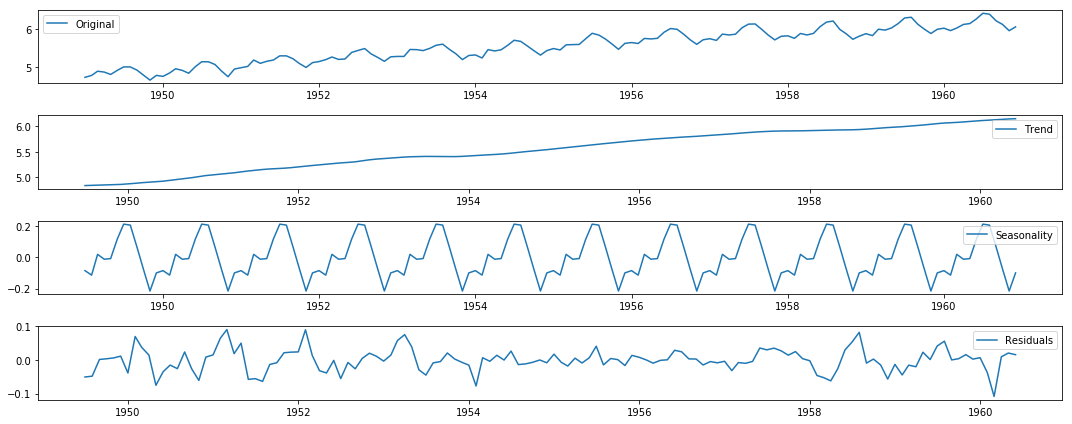

In [125]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Original Time Series에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다.  
이 Residual에 대해 stationality를 분석해 보겠습니다.

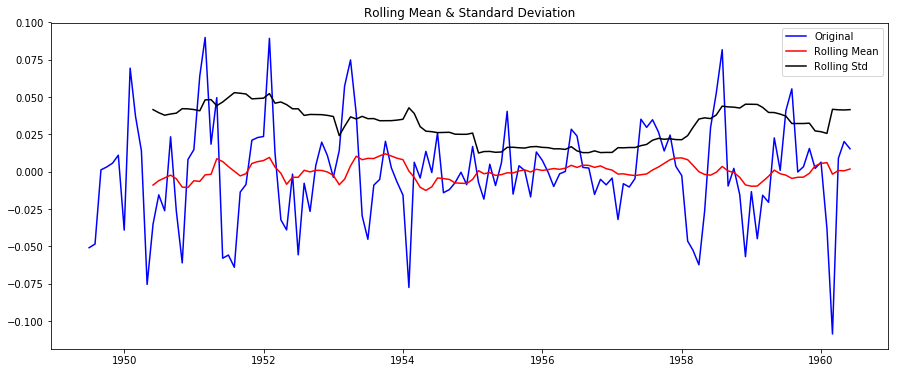

In [126]:
plot_rolling_statistics(residual)

In [128]:
residual.dropna(inplace=True)
dickey_fuller_test(residual['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


Decomposing을 통해 p-value 값이 매우 낮은 Time Series를 도출할 수 있었습니다. 99% 이상의 confidence로 stationary하다고 볼 수 있습니다.  
이런 기법을 통해 stationary한 time series로 변환하면 Future Data를 매우 정확하게 predict할 수 있을 것입니다.